In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import math 

from typing import Tuple 
from mlxtend.frequent_patterns import fpgrowth, association_rules

import util_consts as constants
from helpers import categorise_3, make_categorical

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

INFILE = '/home/grace/work/SEER/data/SEER_2010_2020_RICH.clean.tsv'

In [2]:
table = pd.read_csv(INFILE, sep='\t', header=0)
c_counts = table['cancer_group'].value_counts()
valid = set(c_counts[c_counts>=5000].index.to_list())
table = table[table['cancer_group'].isin(valid)]

/tmp/ipykernel_17856/762226042.py:1: DtypeWarning: Columns (20,21,22,27,28,29,35,36,37,39,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  table = pd.read_csv(INFILE, sep='\t', header=0)


In [3]:
all_columns = table.columns.to_list()
dtypes = table.dtypes.to_dict()
# for field, dtype in dtypes.items():
#     print(field, str(dtype), type(dtype))
all_columns = [c for c in all_columns if c not in constants.UNIVERSAL_NON_PREDICTORS]
all_columns = [c for c in all_columns if c not in constants.UNIVERSAL_PREDICTORS_CATEGORICAL]
all_columns = [c for c in all_columns if c not in constants.UNIVERSAL_PREDICTORS_CONTINUOUS]
all_columns = [c for c in all_columns if type(dtypes[c])!=np.dtypes.ObjectDType]
for cancer_group in table['cancer_group'].unique():
    dfslice = table[table['cancer_group']==cancer_group]
    specific_fields = []
    for col in all_columns:
        if dfslice[col].notna().sum() > 0:
            specific_fields.append(col)

    if len(specific_fields) >= 1:
        print(f"'{cancer_group}': {repr(specific_fields)},")

'Vulva': ['breslow_thick', 'mitotic_rate_melanoma'],
'Prostate': ['PSA', 'gleason'],
'Skin': ['breslow_thick', 'mitotic_rate_melanoma'],
'Colorectal': ['tumor_deposits'],
'Testis': ['AFP_post_orchiectomy'],
'Penis': ['breslow_thick', 'mitotic_rate_melanoma'],



Vulva breslow_thick


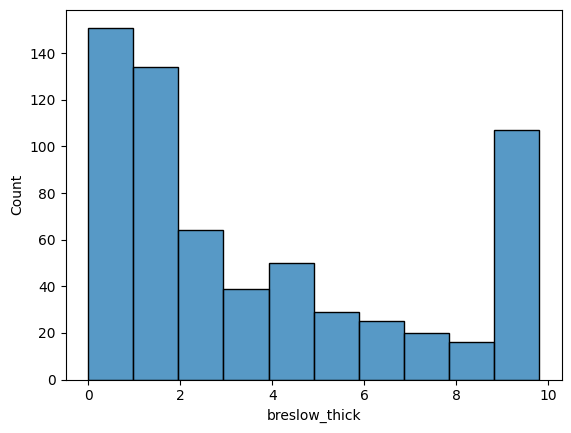

('low', 0, 0.0)
('med', 0.0, 1.4)
('high', 1.4, 10.8)


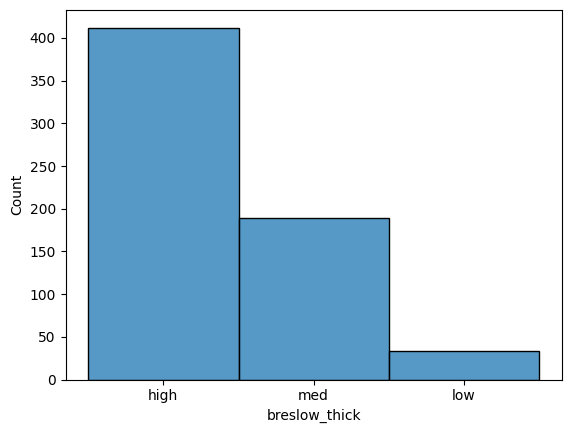


Vulva mitotic_rate_melanoma


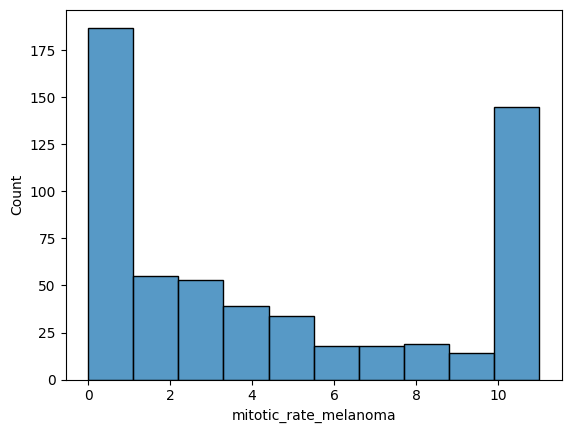

('low', 0, 0.0)
('med', 0.0, 2.0)
('high', 2.0, 12.0)


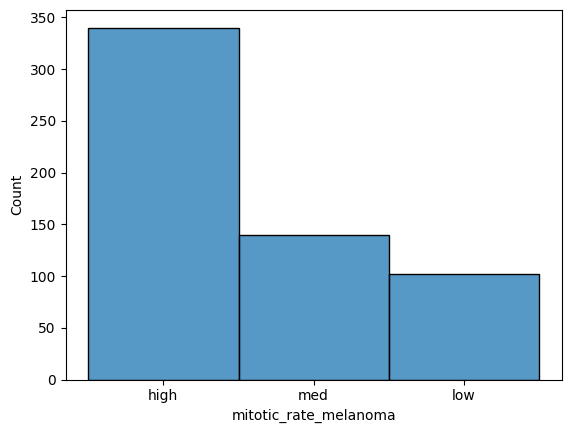


Prostate PSA


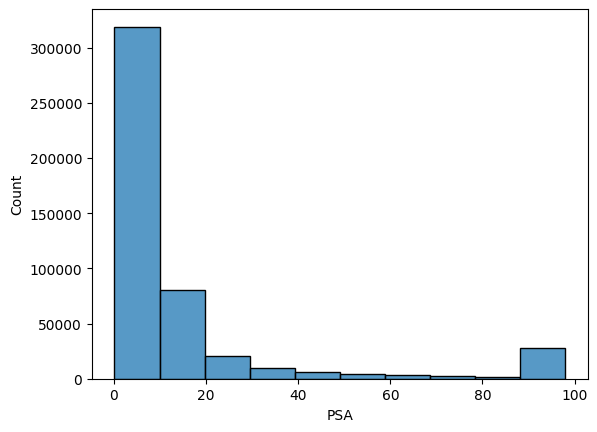

('low', 0, 0.1)
('med', 0.1, 5.6)
('high', 5.6, 99.0)


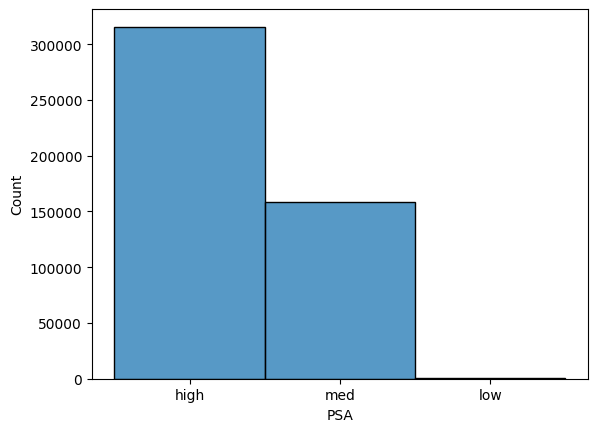


Prostate gleason


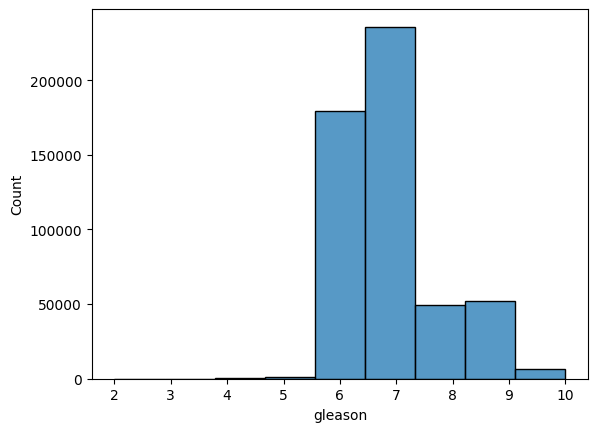

('low', 0, 2.0)
('med', 2.0, 6.0)
('high', 6.0, 11.0)


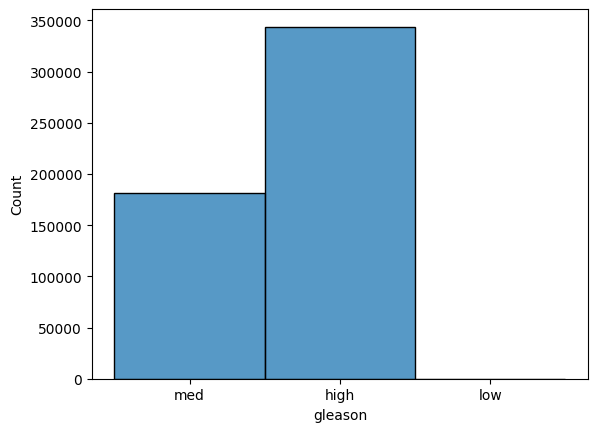


Skin breslow_thick


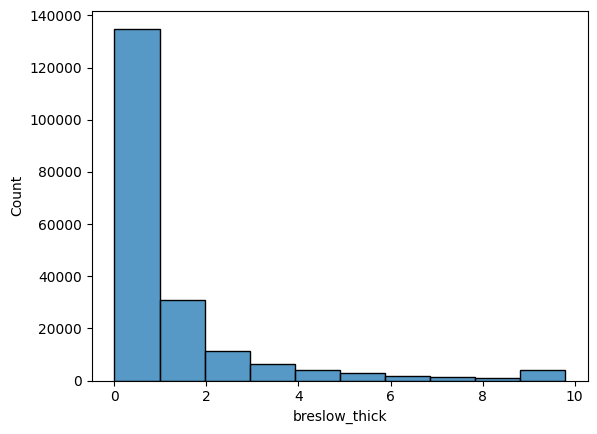

('low', 0, 0.0)
('med', 0.0, 0.4)
('high', 0.4, 10.8)


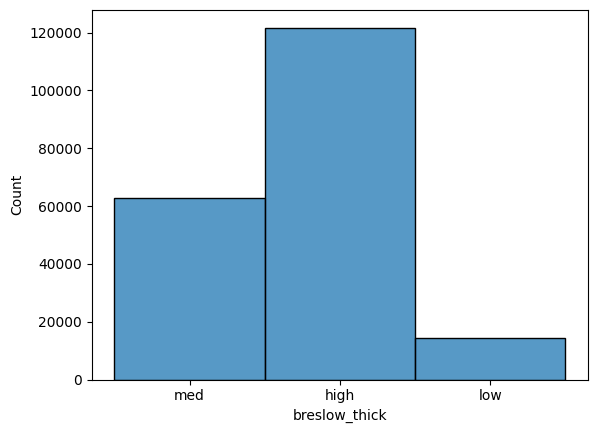


Skin mitotic_rate_melanoma


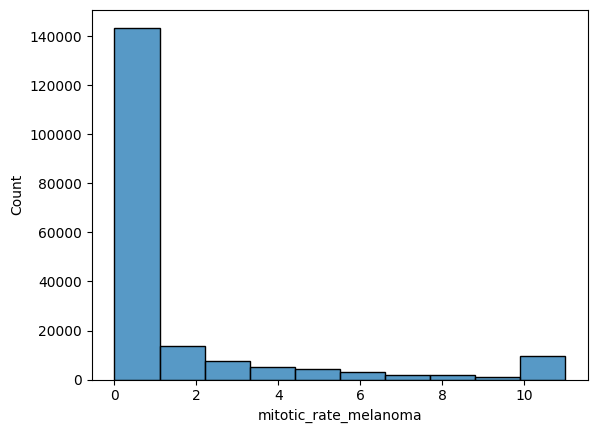

('low', 0, 0.0)
('med', 0.0, 1.0)
('high', 1.0, 12.0)


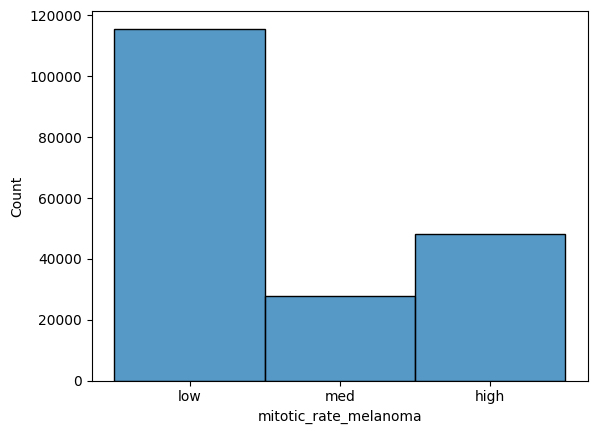


Colorectal tumor_deposits


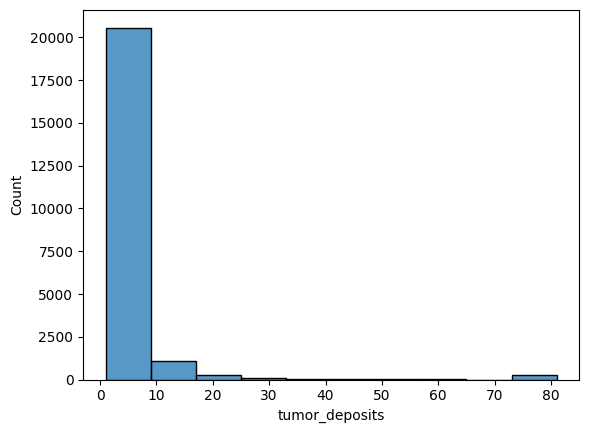

('low', 0, 1.0)
('med', 1.0, 2.0)
('high', 2.0, 82.0)


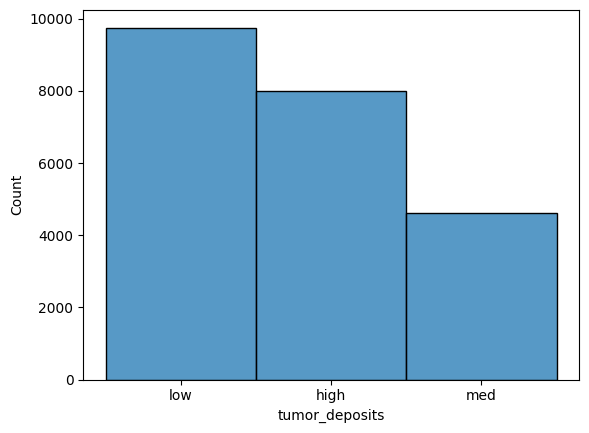


Testis AFP_post_orchiectomy


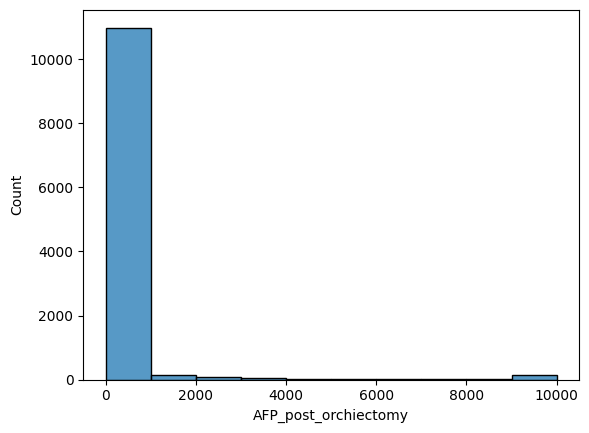

('low', 0, 0.0)
('med', 0.0, 10.0)
('high', 10.0, 10001.0)


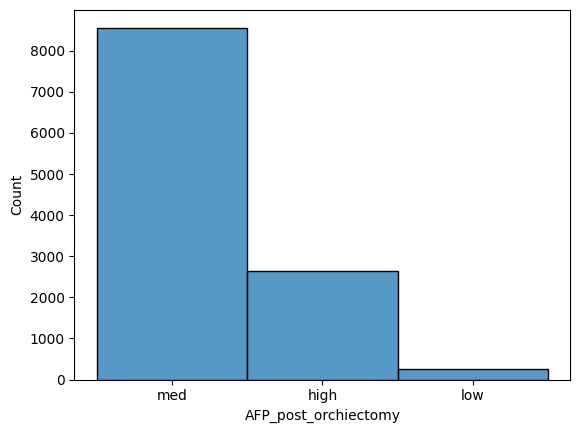


Penis breslow_thick


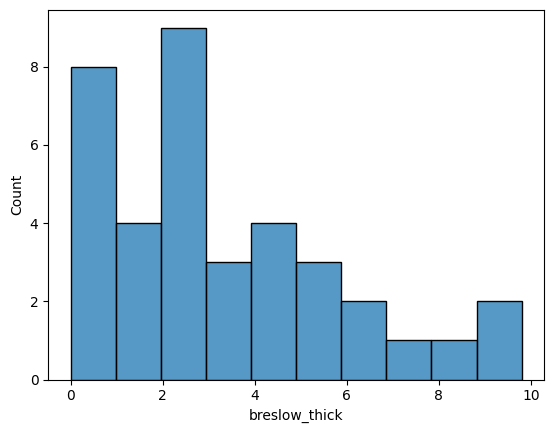

('low', 0, 0.0)
('med', 0.0, 2.0)
('high', 2.0, 10.8)


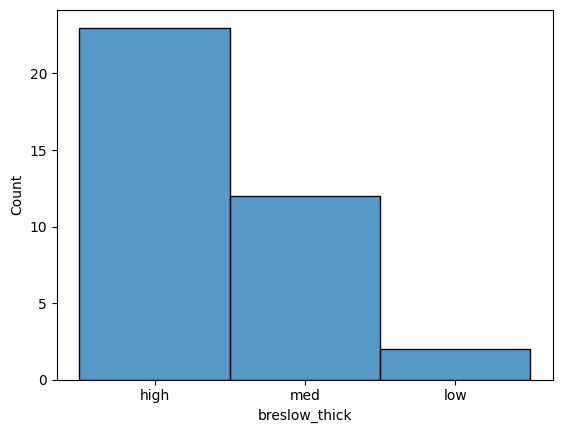


Penis mitotic_rate_melanoma


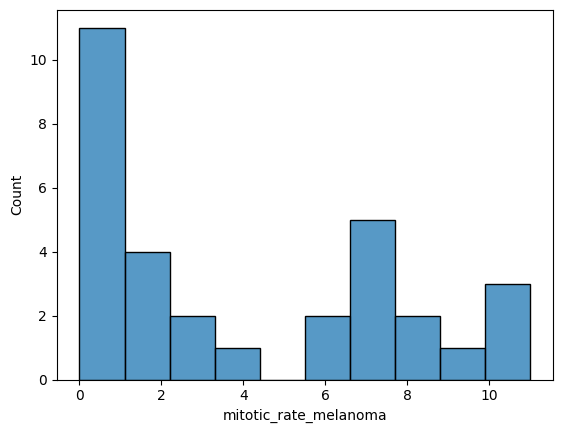

('low', 0, 0.0)
('med', 0.0, 1.0)
('high', 1.0, 12.0)


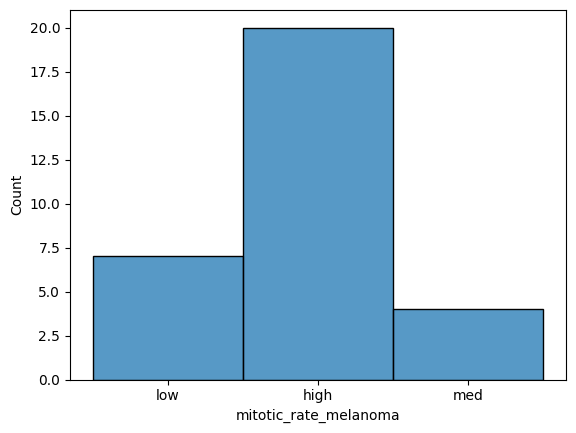

In [9]:

for cancer_group, predictors in constants.SPECIFIC_PREDICTORS_CONTINUOUS.items():
    for pred in predictors:
        print()
        print(cancer_group, pred)
        
        dfslice = table[table['cancer_group']==cancer_group].copy()
        nunique = dfslice[pred].nunique()
        sns.histplot(data=dfslice, x=pred, bins=min(nunique, 10))
        plt.show()

        catranges = categorise_3(dfslice, pred)
        for item in catranges:
            print(item)
        mask = ((dfslice['cancer_group']==cancer_group) & (dfslice[pred].notna()))
        dfslice.loc[mask, 'pred'] = dfslice.loc[mask, pred].apply(make_categorical, ranges=catranges)
        dfslice[pred] = dfslice['pred']
        nunique = dfslice[pred].nunique()
        sns.histplot(data=dfslice, x=pred, bins=min(nunique, 20))
        plt.show()

        # raise NotImplementedError
    
    # print()
    # print(cancer_group)
    # dfslice = table[(table['cancer_group']==cancer_group)]
    # for pred in predictors:
    #     nunique = dfslice[pred].nunique()
    #     sns.histplot(data=dfslice, x=pred, bins=min(nunique, 10))
    #     plt.show()

In [ ]:
cancer_group = 'Prostate'
predictors = constants.UNIVERSAL_PREDICTORS
if cancer_group in constants.CANCER_SPECIFIC_PREDICTORS:
    predictors += constants.CANCER_SPECIFIC_PREDICTORS[cancer_group]


df = table[table['cancer_group']==cancer_group]
df = df[constants.UNIVERSAL_PREDICTORS + constants]
df 


In [6]:
df.head()
# 

# TSTAGE_STD, NSTAGE_STD, GSTAGE_STD, GRADE_STD, hist_group, regional_nodes, 
# PSA to categorical?
# AFP_post_orchiectomy to categorical?

,patient_id,record_number,behavior,sex,age,diagnosis_year,death_year,survival_months,COD,cancer_type,cancer_group,primary_type,primary_group,hist_type,hist_group,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD,GRADE_STD,regional_nodes,chr19q_loh,chr1p_loh,B_symptoms,PSA,gleason,AFP_post_orchiectomy,AFP_pretreat_category,hGC_post_orchiectomy_elevation,LDH_post_orchiectomy_elevation,LDH_pretreatment,HER2_type,HER2_status,breslow_thick,ovarian_CA125,CEA_pretreat,fibrosis_score,adrenal_involvement,major_vein_involvement,mitotic_rate_melanoma,capsule_invasion,perineural_invasion,peripheral_blood_involvement,peritoneal_cytology,pleural_effusion,pleural_invasion,ulceration,tumor_deposits,brain_met,bone_met,liver_met,lung_met,distant_ln_met,other_met,any_met
5,220,1,Malignant,Male,70-74 years,2011,Alive at last contact,118.0,Alive,Prostate,Prostate,Prostate,Prostate,Adenoma [+ others],adenomas and adenocarcinomas,T1,N0,II,G2,NaN,NaN,NaN,NaN,6.6,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,False
6,265,1,Malignant,Male,65-69 years,2011,2016,61.0,Urinary Bladder,Prostate,Prostate,Prostate,Prostate,Adenoma [+ others],adenomas and adenocarcinomas,T2,N0,II,G3,NaN,NaN,NaN,NaN,7.7,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,False
25,709,1,Malignant,Male,60-64 years,2015,Alive at last contact,68.0,Alive,Prostate,Prostate,Prostate,Prostate,Adenoma [+ others],adenomas and adenocarcinomas,T1,N0,II,G2,NaN,NaN,NaN,NaN,7.3,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,False
37,1020,1,Malignant,Male,80-84 years,2013,Alive at last contact,94.0,Alive,Prostate,Prostate,Prostate,Prostate,Adenoma [+ others],adenomas and adenocarcinomas,T1,N0,II,G3,NaN,NaN,NaN,NaN,16.1,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,False
50,1090,2,Malignant,Male,75-79 years,2018,Alive at last contact,25.0,Alive,Prostate,Prostate,Prostate,Prostate,Adenoma [+ others],adenomas and adenocarcinomas,T2,N0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False


In [20]:
print()
print(df['regional_nodes'].value_counts(dropna=False))
print()
print(df['gleason'].value_counts(dropna=False))
print()
print(df['major_vein_involvement'].value_counts(dropna=False))
print()
print(df['capsule_invasion'].value_counts(dropna=False))


regional_nodes
NaN               457795
NEG               112042
POS_NODES           9273
POS_ASPIRATION      1035
Name: count, dtype: int64

gleason
7.0     235857
6.0     179139
NaN      55226
9.0      52373
8.0      49309
10.0      6258
5.0       1396
4.0        414
3.0        118
2.0         55
Name: count, dtype: int64

major_vein_involvement
NaN    580145
Name: count, dtype: int64

capsule_invasion
NaN    580145
Name: count, dtype: int64
